In [1]:
import cv2
import numpy as np

import glob

import time

import pickle

import matplotlib.image as mpimg
import matplotlib.pyplot as plt

from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
from sklearn.svm import LinearSVC
from scipy.ndimage.measurements import label
import os
from sklearn.preprocessing import StandardScaler
# NOTE: the next import is only valid 
# for scikit-learn version <= 0.17
# if you are using scikit-learn >= 0.18 then use this:
# from sklearn.model_selection import train_test_split
from sklearn.cross_validation import train_test_split

C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
spatial_size=(32, 32)
hist_bins=32
orient=9
pix_per_cell=8 
cell_per_block=2 
hog_channel=0
                     
spatial_feat=True
hist_feat=True
hog_feat=True

In [3]:
# load the dataset
# path_dataset_vehicle = ./dataset/vehicles
# path_dataset_nonvehicle = ./dataset/non-vehicles

# vehicles

veh_gti_far = glob.glob('./dataset/vehicles/GTI_Far/*.png')
veh_gti_l = glob.glob('./dataset/vehicles/GTI_Left/*.png')
veh_gti_mid_close = glob.glob('./dataset/vehicles/GTI_MiddleClose/*.png')
veh_gti_r = glob.glob('./dataset/vehicles/GTI_Right/*.png')
veh_kitti = glob.glob('./dataset/vehicles/KITTI_extracted/*.png')

#non vehicles
nonveh_extras = glob.glob('./dataset/non-vehicles/Extras/*.png')
nonveh_gti = glob.glob('./dataset/non-vehicles/GTI/*.png')

# evaluate the dataset
len_veh_gti_far = len(veh_gti_far)
len_veh_gti_l = len(veh_gti_l)
len_veh_gti_mid_close = len(veh_gti_mid_close)
len_veh_gti_r = len(veh_gti_r)
len_veh_kitti = len(veh_kitti)
len_all_veh = len_veh_gti_far + len_veh_gti_l + len_veh_gti_mid_close \
    + len_veh_gti_r + len_veh_kitti


len_nonveh_extras = len(nonveh_extras)
len_nonveh_gti = len(nonveh_gti)
len_all_non_veh =len_nonveh_extras+len_nonveh_gti

print('veh_gti_far length: {}' .format(len_veh_gti_far))
print('veh_gti_l length: {}' .format(len_veh_gti_l))
print('veh_gti_far length: {}' .format(len_veh_gti_mid_close))
print('veh_gti_far length: {}' .format(len_veh_gti_r))
print('veh_gti_far length: {}' .format(len_veh_kitti))
print('nonveh_extras length: {}' .format(len_nonveh_extras))
print('nonveh_gti length: {}' .format(len_nonveh_gti))

print('Total Vehicles: {} Total Non Vehicles: {}' .format(len_all_veh,len_all_non_veh ))

veh_gti_far length: 834
veh_gti_l length: 909
veh_gti_far length: 419
veh_gti_far length: 664
veh_gti_far length: 5966
nonveh_extras length: 5068
nonveh_gti length: 3900
Total Vehicles: 8792 Total Non Vehicles: 8968


In [4]:
# shuffle and split the data 
all_veh = veh_gti_far + veh_gti_l + veh_gti_mid_close \
    + veh_gti_r + veh_kitti

all_non_veh = nonveh_extras + nonveh_gti

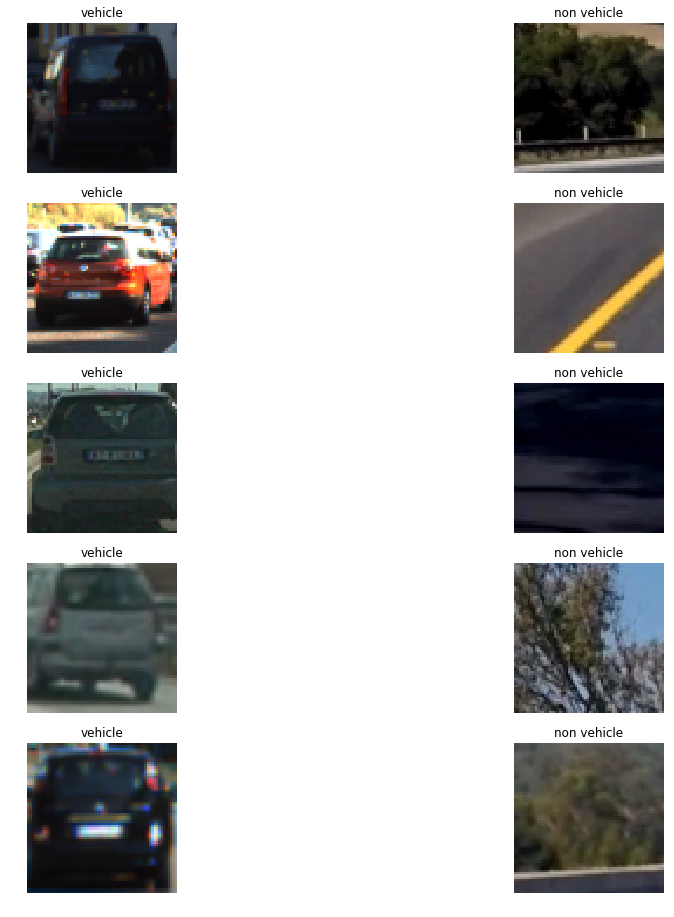

In [5]:
%matplotlib inline
# plt.rcParams['figure.figsize'] = (20,20)
# plt.rcParams['figure.figsize'] = (10.0, 8.0)
# matplotlib.rcParams['figure.figsize'] = (10.0, 8.0)

#print ('rows: {}' .format(rows))

n_examples = 5
columns = 2
w = 16
h = 16
# fig=plt.figure(figsize=(180, 160), dpi= 80, facecolor='w', edgecolor='k')
fig, axes = plt.subplots(n_examples,columns, figsize=(w,h))
axes = axes.ravel()
for i in range(len(axes)):
    axes[i].axis('off')
    
# iterate through the classes and pull together useful information
for i in range(n_examples): 
    axes[i * 2].imshow(mpimg.imread(all_veh[np.random.randint(0,len(all_veh)-1)]))
    axes[i * 2].set_title('vehicle')
    axes[i * 2 +1].imshow(mpimg.imread(all_non_veh[np.random.randint(0,len(all_non_veh)-1)]))
    axes[i * 2 +1].set_title('non vehicle')

In [6]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False,
                       visualise=False, feature_vector=feature_vec)
        return features

In [7]:
def plot_figure(array_to_plot, labels_array, n_rows, n_columns, figuresize=(64,64),colourmap='gray'):
    fig, axes = plt.subplots( n_rows, n_columns,figsize=figuresize)
    axes = axes.ravel()

    for i in range(len(array_to_plot)):
        print('i {}'.format(i))
        print('title {}'.format(labels_array[i]))
        axes[i].imshow(array_to_plot[i], cmap=colourmap)
        axes[i].set_title(labels_array[i])
        axes[i].axis('off')

    # TODO Reinstate
    plt.tight_layout()
    plt.show()
    plt.savefig('./output_images/dataset_samples.png')

In [8]:
def explore_hog(veh_img,gray):

    %matplotlib inline
    plt.rcParams['figure.figsize'] = (20,20)
    
    print ('function to visualise the dataset and hog output')

    i=0
    rows = 2
    columns = 4
    w = 16
    h = 16
    
    # fig=plt.figure(figsize=(180, 160), dpi= 80, facecolor='w', edgecolor='k')
    fig, axes = plt.subplots(rows,columns, figsize=(w,h))
    plt.tight_layout()
    fig.subplots_adjust(hspace = .1, wspace=.5)    
    
    axes = axes.ravel()
    # for i in range(len(axes)):
    #     axes[i].axis('off')
        
    # iterate through the classes and pull together useful information
    # for i in range(n_examples): 
    # veh_img = mpimg.imread(all_veh[rnd])
    axes[i*0].set_title('vehicle')   
    axes[i*0].imshow(veh_img)

    axes[i*4+1].set_title('chn0')     
    axes[i*4+1].imshow(veh_img[:,:,0], cmap='gray')
    axes[i*4+2].set_title('chn1')
    axes[i*4+2].imshow(veh_img[:,:,1], cmap='gray')
    axes[i*4+3].set_title('chn2')     
    axes[i*4+3].imshow(veh_img[:,:,2], cmap='gray')
       

    
    i+=1
    features, hog_image = get_hog_features(gray, orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)
    axes[i*4].set_title('gray')    
    axes[i*4].imshow(hog_image, cmap='gray')
    
    features, hog_image = get_hog_features(veh_img[:,:,0], orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)
    axes[i*4+1].set_title('chn0')    
    axes[i*4+1].imshow(hog_image, cmap='gray')
      
    features, hog_image = get_hog_features(veh_img[:,:,1], orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)
    axes[i*4+2].set_title('chn1')    
    axes[i*4+2].imshow(hog_image, cmap='gray')

    features, hog_image = get_hog_features(veh_img[:,:,2], orient,
                                           pix_per_cell, cell_per_block,
                                           vis=True, feature_vec=False)
    axes[i*4+3].set_title('chn2')    
    axes[i*4+3].imshow(hog_image, cmap='gray')

In [9]:
def convert_color(img, cspace='YCrCb'):
    if cspace != 'RGB':
        if cspace == 'HSV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            return cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            return cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif cspace == 'LAB':
            return cv2.cvtColor(img, cv2.COLOR_RGB2LAB) 
    else: 
        return np.copy(img)

In [10]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

In [11]:
# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

In [12]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_from_course(files, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in files:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        feature_image = convert_color(img, cspace)

        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


def extract_imgs_features(files, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=True, hist_feat=True, hog_feat=True): 
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in files:
        img = mpimg.imread(file)
        # plt.imshow(img)
        flip = False
        if flip:
            newfeatures, rev_newfeatures = single_img_features_with_flip(img, cspace=cspace, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=hog_channel,
                        spatial_feat=False, hist_feat=False, hog_feat=True)
            features.append(newfeatures)
            features.append(rev_newfeatures)
            
        else:
            features.append(single_img_features(img, cspace=cspace, spatial_size=(32, 32),
                        hist_bins=32, orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=hog_channel,
                        spatial_feat=False, hist_feat=False, hog_feat=True))
    return features

In [13]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features(img, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=False, hog_feat=True, hist_feat=False):    
    #1) Define an empty list to receive features
    img_features = []
    
    # print('image shape: {}' .format(img.shape))
    
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, cspace)   
  
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        # print('hog_feat')
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                # print('Using ALL channels'.format(hog_channel))
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))      
        else:
            # print('Using single channel: {}'.format(hog_channel))
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        # print('img_features len: {}' .format(len(img_features)))

    #9) Return concatenated array of features
    return np.concatenate(img_features)

print('end of cell')

end of cell


In [14]:
# Define a function to extract features from a single image window
# This function is very similar to extract_features()
# just for a single image rather than list of images
def single_img_features_with_flip(img, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, orient=9,
                        pix_per_cell=8, cell_per_block=2, hog_channel=0,
                        spatial_feat=False, hog_feat=True, hist_feat=False):
    #1) Define an empty list to receive features
    img_features = []
    rev_img_features = []
    #2) Apply color conversion if other than 'RGB'
    feature_image = convert_color(img, cspace)        
    
    reversed_image =np.copy(cv2.flip(feature_image, 1 ))
    
    #3) Compute spatial features if flag is set
    if spatial_feat == True:
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        #4) Append features to list
        img_features.append(spatial_features)
    #5) Compute histogram features if flag is set
    if hist_feat == True:
        hist_features = color_hist(feature_image, nbins=hist_bins)
        #6) Append features to list
        img_features.append(hist_features)
    #7) Compute HOG features if flag is set
    if hog_feat == True:
        if hog_channel == 'ALL':
            hog_features = []
            rev_hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.extend(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))  

                rev_hog_features.extend(get_hog_features(reversed_image[:,:,channel], 
                    orient, pix_per_cell, cell_per_block, 
                    vis=False, feature_vec=True)) 
                
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
            rev_hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        #8) Append features to list
        img_features.append(hog_features)
        rev_img_features.append(rev_hog_features)     

        # print('img_features len: {}' .format(len(img_features)))

    #9) Return concatenated array of features
    return np.concatenate(img_features),  np.concatenate(rev_img_features)

In [15]:
def split_dataset(X, y):
    
    # Split up data into randomized training and test sets
    rand_state = np.random.randint(0, 100)
    # X_train, X_test, y_train, y_test = train_test_split(
    #     scaled_X, y, test_size=0.2, random_state=rand_state)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=rand_state)
    
    print('X_train len: {}' .format(len(X_train)))
    print('X_train len: {}' .format(len(y_train)))
    print('X_test len: {}' .format(len(X_test)))
    print('y_test len: {}' .format(len(y_test)))
    # 
    return X_train, X_test, y_train, y_test

In [16]:
def get_features(cspace, hog_channel ):
    # print('extracting features')
    car_features = extract_imgs_features(cars, cspace=cspace, spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=hog_channel,
                            spatial_feat=False, hist_feat=False, hog_feat=True)
    notcar_features = extract_imgs_features(notcars, cspace=cspace, spatial_size=(32, 32),
                            hist_bins=32, orient=9, 
                            pix_per_cell=8, cell_per_block=2, hog_channel=hog_channel,
                            spatial_feat=False, hist_feat=False, hog_feat=True)
    print('done extracting features')
    # Create an array stack of feature vectors
    X = np.vstack((car_features, notcar_features)).astype(np.float64)
    
    # Define the labels vector
    y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
    print ('car_features len: {}, notcar_features' .format(len(notcar_features)))
    return X, y

In [17]:
def train_svc(X_train, y_train, X_test, y_test, svc):

    t=time.time()
    svc.fit(X_train, y_train)
    t2 = time.time()
    train_time = round(t2-t, 2)
    print(train_time, 'Seconds to train SVC...')
    # Check the score of the SVC
    acc =  round(svc.score(X_test, y_test), 4)
    print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
    # Check the prediction time for a single sample
    t=time.time()
    return svc, acc, train_time

In [18]:
def predict_svn(X_test, y_test, svc):
    n_predict = 10
    t=time.time()
    print('My SVC predicts: \t', svc.predict(X_test[0:n_predict]))
    print('For these',n_predict, 'labels: \t', y_test[0:n_predict])
    t2 = time.time()
    print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')
    return svc

In [19]:
def train_predict(cspace, hog_channel, svc):
    
    print('-----------------------------------------------------------')
    msg = ('Colourspace: {}, hog channel: {}' .format(cspace, hog_channel))
    print(msg)
    X, y = get_features(cspace, hog_channel )
    X_train, X_test, y_train, y_test = split_dataset(X,y)
    
    # Use a linear SVC 
    # print('creating svc')
    # svc = LinearSVC()
    # print('done creating svc')
    svc, acc,train_time = train_svc(X_train, y_train, X_test, y_test, svc)
    svc = predict_svn(X_test, y_test, svc)
    msg = msg + '- \taccuracy: {}' .format(acc) + '\ttrain time: {}' .format(train_time)
    print(msg)
    return svc, X, y
    print('-----------------------------------------------------------')

In [20]:
# TODO play with these values to see how your classifier
# performs under different binning scenarios
spatial = 32
histbin = 32

print('running')
cars = all_veh
notcars = all_non_veh


global_colour_space = 'HLS'
global_channel = 'ALL'
X = None
y = None

# train_predict('YCrCb', 'ALL')
svc = LinearSVC()
sandbox = False
if sandbox:
    cspaces =  ['RGB', 'HLS', 'HSV', 'YUV', 'LUV', 'YCrCb', 'LAB']
    channels =  ['ALL', 0, 1,2]

    for cspace in cspaces:
        for channel in channels:
        # call the svn
            svc, X, y = train_predict(cspace, channel, svc) 
else:
    svc, X, y = train_predict(global_colour_space, global_channel, svc) 
 
print('done')

running
-----------------------------------------------------------
Colourspace: HLS, hog channel: ALL


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


done extracting features
car_features len: 8968, notcar_features
X_train len: 14208
X_train len: 14208
X_test len: 3552
y_test len: 3552
8.21 Seconds to train SVC...
Test Accuracy of SVC =  0.984
My SVC predicts: 	 [ 0.  0.  0.  1.  0.  0.  1.  1.  1.  0.]
For these 10 labels: 	 [ 0.  0.  0.  1.  0.  0.  1.  1.  1.  0.]
0.001 Seconds to predict 10 labels with SVC
Colourspace: HLS, hog channel: ALL- 	accuracy: 0.984	train time: 8.21
done


In [21]:
# svc = train_svc(X_train, y_train)

In [22]:
# n_predict = 10
# print('My SVC predicts: \t', svc.predict(X_test[0:n_predict]))
# print('For these',n_predict, 'labels: \t', y_test[0:n_predict])
# t2 = time.time()
# print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

In [23]:
def save_model(filename):
    with open(filename, 'wb') as save_file:
        pickle.dump(
            {   'svc':svc, 
                # 'scaler': X_scaler,
                'orient': orient,
                'pix_per_cell': pix_per_cell,       
                'cell_per_block': cell_per_block,
                'spatial_size': spatial_size,
                'hist_bins': hist_bins,
            },
            save_file, pickle.HIGHEST_PROTOCOL)

In [24]:
save_model('svc_pickle.p')

In [25]:
# Start of the sliding window functioality

# Define a function you will pass an image 
# and the list of windows to be searched (output of slide_windows())
def search_windows(img, windows, clf, scaler, color_space='RGB', 
                    spatial_size=(32, 32), hist_bins=32, 
                    hist_range=(0, 256), orient=9, 
                    pix_per_cell=8, cell_per_block=2, 
                    hog_channel=0, spatial_feat=True, 
                    hist_feat=True, hog_feat=True):

    #1) Create an empty list to receive positive detection windows
    on_windows = []
    #2) Iterate over all windows in the list
    for window in windows:
        #3) Extract the test window from original image
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))      
        #4) Extract features for that window using single_img_features()
        features = single_img_features(test_img, color_space=color_space, 
                            spatial_size=spatial_size, hist_bins=hist_bins, 
                            orient=orient, pix_per_cell=pix_per_cell, 
                            cell_per_block=cell_per_block, 
                            hog_channel=hog_channel, spatial_feat=spatial_feat, 
                            hist_feat=hist_feat, hog_feat=hog_feat)
        #5) Scale extracted features to be fed to classifier
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        #6) Predict using your classifier
        prediction = clf.predict(test_features)
        #7) If positive (prediction == 1) then save the window
        if prediction == 1:
            on_windows.append(window)
    #8) Return windows for positive detections
    return on_windows

In [26]:
#load data from files

dist_pickle = pickle.load( open("./svc_pickle.p", "rb" ) )
svc = dist_pickle["svc"]
# X_scaler = dist_pickle["scaler"]
orient = dist_pickle["orient"]
pix_per_cell = dist_pickle["pix_per_cell"]
cell_per_block = dist_pickle["cell_per_block"]
spatial_size = dist_pickle["spatial_size"]
hist_bins = dist_pickle["hist_bins"]

In [27]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy

In [28]:
# extracted the code to get the searchable portion of the image into its own meth
def get_image_to_search(full_img, ystart, ystop):
    img_tosearch = full_img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace='RGB2YCrCb')
    # plt.imshow(ctrans_tosearch)
    return ctrans_tosearch

image shape: (720, 1280, 3)


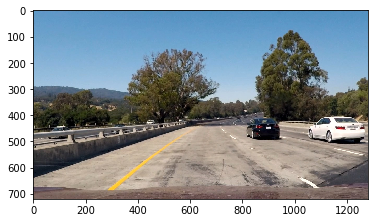

In [29]:
# 

img = mpimg.imread('./test_images/test1.jpg')
plt.imshow(img)
print('image shape: {}'.format(img.shape))
    
# ystart = 400
# ystop = 656
# scale = 1.5
# ctrans_tosearch = get_image_to_search(img, ystart, ystop)

In [30]:
class Rect():
    def __init__(self, xbox_left, ytop_draw, win_draw):
        self.image_raw = False
        self.xbox_left = xbox_left
        self.ytop_draw = ytop_draw
        self.win_draw = win_draw
        # create a box variable in the format the heat map expects
        self.box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))

In [31]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, svc, X_scaler, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins):
    

    posi_boxes = []
    negi_boxes = []
    
    # print('image shape: {}'.format(img.shape))
    
    
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    # 
    # ctrans_tosearch = get_image_to_search(img, ystart, ystop)
    # print('image shape: {}'.format(ctrans_tosearch.shape))
    img_tosearch = img[ystart:ystop,:,:]
    ctrans_tosearch = convert_color(img_tosearch, cspace=global_colour_space)
    
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) - cell_per_block + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) - cell_per_block + 1 
    nfeat_per_block = orient*cell_per_block**2
    
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - cell_per_block + 1
    # print('nblocks_per_window: {}' .format(nblocks_per_window))
    cells_per_step = 1  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
    hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            if (global_channel == 0):
                hog_features = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            elif (global_channel == 1):
                hog_features = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            elif (global_channel == 2):
                hog_features = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
            elif(global_channel == 'ALL'):
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()            
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
                
          
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            test_prediction = svc.predict(hog_features.reshape(1, -1))    
            
            xbox_left = np.int(xleft*scale)
            ytop_draw = np.int(ytop*scale)
            win_draw = np.int(window*scale)
            if test_prediction == 1:
                # xbox_left = np.int(xleft*scale)
                # ytop_draw = np.int(ytop*scale)
                # win_draw = np.int(window*scale)
                # cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                # rect = Rect(xbox_left, ytop_draw, win_draw)
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                posi_boxes.append(box)
            else:
                box = ((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart))
                negi_boxes.append(box)
                
    for box in negi_boxes:
        # xbox_left = rect.xbox_left
        # ytop_draw = rect.ytop_draw
        # win_draw = rect.win_draw
        # cv2.rectangle(draw_img ,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6)            
        cv2.rectangle(draw_img ,box[0],box[1],(0,0,255),6)                                    
    
    for box in posi_boxes:
        # xbox_left = rect.xbox_left
        # ytop_draw = rect.ytop_draw
        # win_draw = rect.win_draw
        # cv2.rectangle(draw_img ,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(255,0,0),6)            
        cv2.rectangle(draw_img ,box[0],box[1],(255,0,0),6)       
                
    return draw_img, posi_boxes, negi_boxes

In [32]:
# get the boxes for the found cars in an image
def get_boxes_from_image(img):
    ystart = 400
    ystop = 500
    scale = 1
    out_img_1, posi_boxes_1, neg_boxes_1 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 400
    ystop = 656    
    scale = 1.5
    out_img_15, posi_boxes_15, neg_boxes_15 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale = 2
    out_img_2, posi_boxes_2, neg_boxes_2 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

    scale = 3
    out_img_3, posi_boxes_3, neg_boxes_3 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
    ystart = 380
    ystop = 656
    scale = 4
    out_img_4, posi_boxes_4, neg_boxes_4 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)


    all_posi_boxes =  posi_boxes_1 + posi_boxes_2 + posi_boxes_3 + posi_boxes_4
    return all_posi_boxes, out_img_1, out_img_2, out_img_3, out_img_4

C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


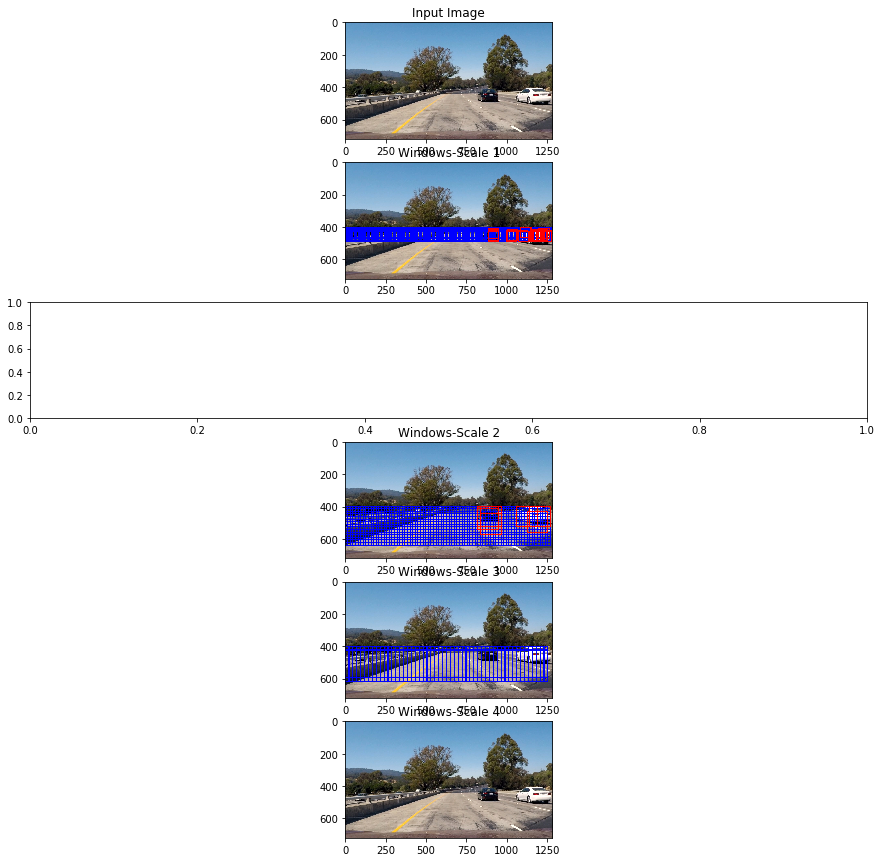

In [33]:
# ystart = 400
# ystop = 560
# scale = 1
# out_img_1, posi_boxes_1, negi_boxes_1 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# 
# ystart = 400
# ystop = 656
# scale = 1.5
# out_img_15, posi_boxes_15, neg_boxes_15 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# 
# ystart = 400
# ystop = 656
# scale = 2
# out_img_2, posi_boxes_2, neg_boxes_2 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# 
# ystart = 400
# ystop = 656
# scale = 3
# out_img_3, posi_boxes_3, neg_boxes_3 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)
# 
# scale = 4
# ystart = 360
# ystop = 656
# out_img_4, posi_boxes_4, neg_boxes_3 = find_cars(img, ystart, ystop, scale, svc, X, orient, pix_per_cell, cell_per_block, spatial_size, hist_bins)

all_posi_boxes, out_img_1, out_img_2, out_img_3, out_img_4 = get_boxes_from_image(img)
# plt.imshow(out_img)

fig = plt.figure()
fig.set_figheight(32)
fig.set_figwidth(32)
fig.set_figheight(15)
fig.set_figwidth(15)
plt.subplot(611)
plt.imshow(img)
plt.title('Input Image')
plt.subplot(612)
plt.imshow(out_img_1)
plt.title('Windows-Scale 1')
plt.subplot(613)
# plt.imshow(out_img_15)
# plt.title('Windows-Scale 1.5')
plt.subplot(614)
plt.imshow(out_img_2)
plt.title('Windows-Scale 2')
plt.subplot(615)
plt.imshow(out_img_3)
plt.title('Windows-Scale 3')
plt.subplot(616)
plt.imshow(out_img_4)
plt.title('Windows-Scale 4')

# fig.tight_layout()
plt.savefig('./output_images/windows_all.png',bbox_inches='tight')

In [34]:
filename = 'bbox_pickle.p'
with open(filename, 'wb') as save_file:
    pickle.dump( all_posi_boxes, open( filename, "wb" ) )

In [35]:
# Read in a pickle file with bboxes saved
# Each item in the "all_bboxes" list will contain a 
# list of boxes for one of the images shown above
all_posi_boxes = pickle.load( open( "bbox_pickle.p", "rb" ))

# # Read in image similar to one shown above 
# image = mpimg.imread('test_image.jpg')
# heat = np.zeros_like(image[:,:,0]).astype(np.float)

In [36]:
def add_heat(heatmap, boxes):
    # Iterate through list of bboxes
    for box in boxes:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap# Iterate through list of bboxes

In [37]:
# apply a threshold to heatmap. Anything less that the threshold is discarded.
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap

In [38]:
# draw bounding box using the max and min of the labels
#the labels were created from the heatmaps
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    # print('labels count')
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img

video: False


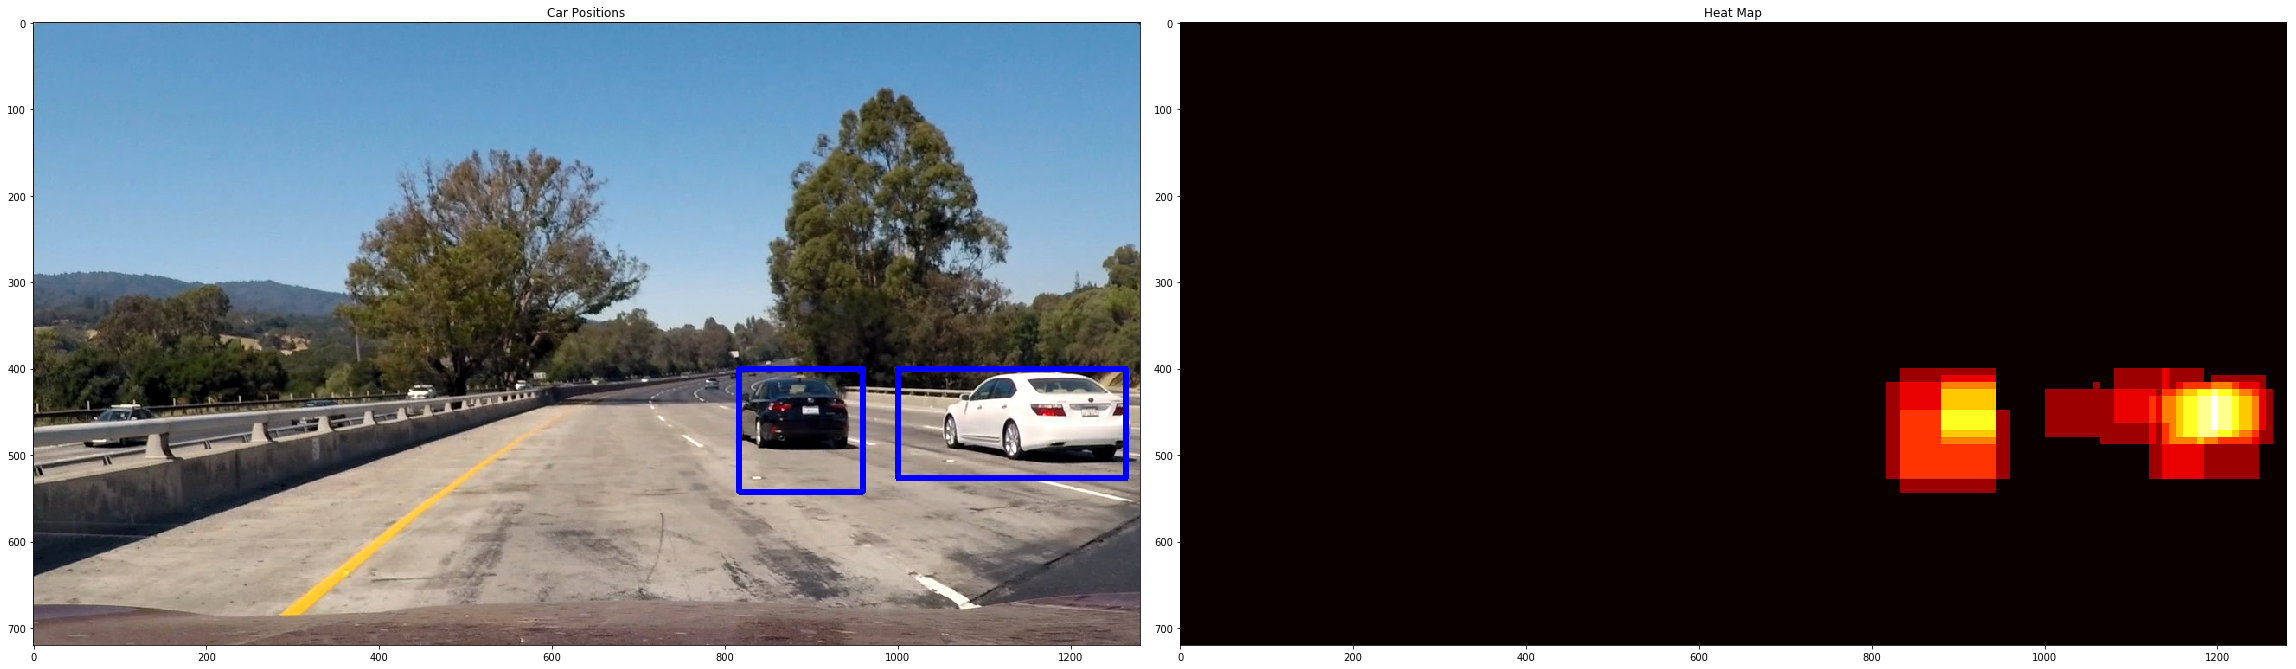

In [39]:
# get the bounding boxes of each car by creating heat maps and thresholding
def get_bb_via_heat(img, boxes, video=False):
#     print('boxes : {}' .format((boxes)))
    heat = np.zeros_like(np.copy(img[:,:,0]))
    threshold = 1    
    
    print('video: {}'.format(video))
    if video == True:
        threshold = 12
        no_of_frames_to_avg = 16
        current_frame_boxes = list(boxes)
        
        recent_frame_boxes.append(current_frame_boxes)
#         print('recent_frame_boxes len: {}' .format(len(recent_frame_boxes)))
#         print('recent_frame_boxes shape: {}' .format((recent_frame_boxes.shape)))
        if (len(recent_frame_boxes) > no_of_frames_to_avg) :
            del recent_frame_boxes[0]

        boxes = []
        for frame_boxes in recent_frame_boxes: 
            boxes = boxes + frame_boxes
#         print('boxes : {}' .format((boxes)))
#         print('boxes len: {}' .format(len(boxes)))
#         heat = add_heat(heat, boxes)
    # Add heat to each box in box list

    heat = add_heat(heat, boxes)

        
    # Apply threshold to help remove false positives
    heat = apply_threshold(heat,threshold)
    
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat, 0, 255)
    
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    draw_img = draw_labeled_bboxes(np.copy(img), labels)
    return draw_img, heatmap


draw_img, heatmap = get_bb_via_heat(img, all_posi_boxes)    
recent_frame_boxes = []
fig = plt.figure()
fig.set_figheight(32)
fig.set_figwidth(32)
plt.subplot(121)
plt.imshow(draw_img)
plt.title('Car Positions')
plt.subplot(122)
plt.imshow(heatmap, cmap='hot')
plt.title('Heat Map')
fig.tight_layout()
plt.savefig('./output_images/heatmap.png',bbox_inches='tight')

In [41]:
# method to process an image 
def process_image(img):
    all_posi_boxes, out_img_1, out_img_2, out_img_3,out_img_4 = get_boxes_from_image(img)
    # all_posi_boxes =  posi_boxes_1 + posi_boxes_15 + posi_boxes_2 + posi_boxes_3 + posi_boxes_4
    draw_img, heatmap = get_bb_via_heat(img, all_posi_boxes, False) 

    return draw_img

In [42]:
def process_image_video(img):
    all_posi_boxes, out_img_1, out_img_2, out_img_3 , out_img_4 = get_boxes_from_image(img)
    # all_posi_boxes =  posi_boxes_1 + posi_boxes_15 + posi_boxes_2 + posi_boxes_3 + posi_boxes_4
    draw_img, heatmap = get_bb_via_heat(img, all_posi_boxes, True) 

    return draw_img

processing file: ./test_images\test1.jpg


C:\Users\georg\Miniconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


video: False
processing file: ./test_images\test2.jpg
video: False
processing file: ./test_images\test3.jpg
video: False
processing file: ./test_images\test4.jpg
video: False
processing file: ./test_images\test5.jpg
video: False
processing file: ./test_images\test6.jpg
video: False


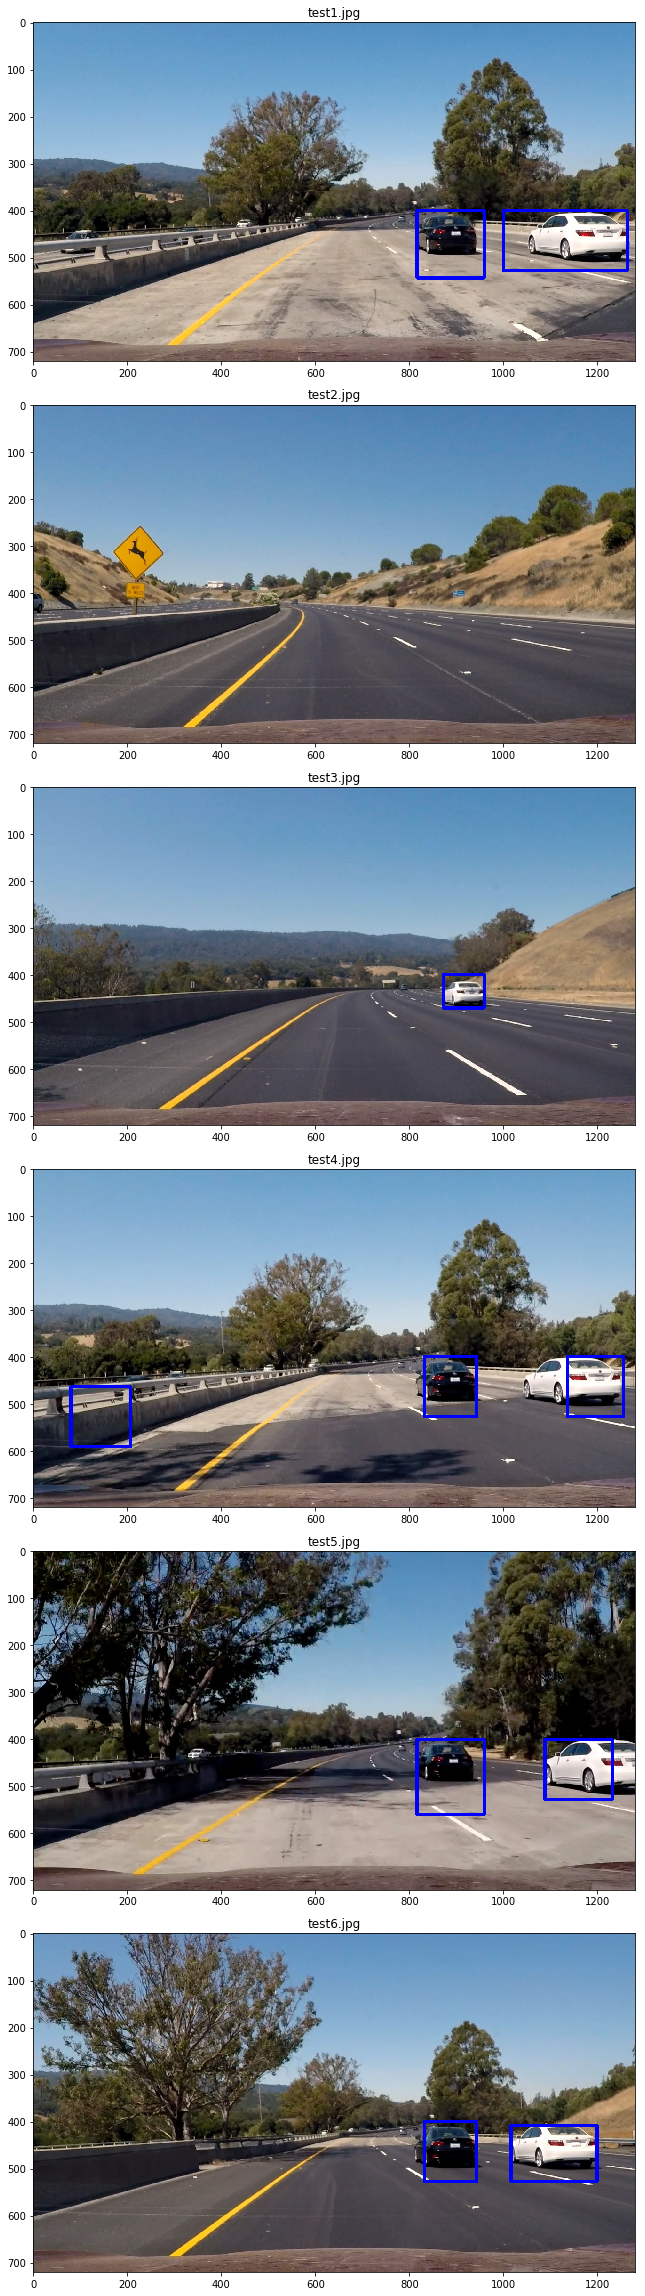

In [ ]:
# parse the test images and call the process image method
test_image_files = glob.glob('./test_images/*.jpg')
processed_imgs = []
num_imgs =  len(test_image_files)
fig = plt.figure()
subplot_ind = 11 + num_imgs * 100
fig.set_figheight(32)
fig.set_figwidth(32)

for file in test_image_files:
    print ('processing file: {}' .format(file))
#     print(os.path.basename(file))
    # processed_imgs.append(process_image(img))
    img = mpimg.imread(file)
    plt.subplot(subplot_ind)
    plt.title(os.path.basename(file))
    processed_img = process_image(img)
    plt.imshow(processed_img)


    subplot_ind += 1

fig.tight_layout()

plt.savefig('./output_images/test_images_output.png',bbox_inches='tight')

In [ ]:
# process a video, which in turn call the process_image method
from moviepy.editor import VideoFileClip
from IPython.display import HTML

recent_frame_boxes = []

def process_video(input_video_filename, output_video_filename):
#     output_video = 'output.mp4'
    clip1 = VideoFileClip(input_video_filename)


    output_clip = clip1.fl_image(process_image_video)
    output_clip.write_videofile(output_video_filename, audio=False)

# process_image(image)


output_video_filename = 'project_video_output.mp4'
# input_video_filename = 'test_video.mp4'
# input_video_filename = 'project_video.mp4'
input_video_filename = 'challenge_video.mp4'

process_video(input_video_filename, output_video_filename)

video: True
[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


  0%|          | 0/485 [00:00<?, ?it/s]

video: True


  0%|          | 1/485 [00:00<05:32,  1.46it/s]

video: True


  0%|          | 2/485 [00:01<05:33,  1.45it/s]

video: True


  1%|          | 3/485 [00:02<05:41,  1.41it/s]

video: True


  1%|          | 4/485 [00:02<05:39,  1.42it/s]

video: True


  1%|          | 5/485 [00:03<05:38,  1.42it/s]

video: True


  1%|          | 6/485 [00:04<05:36,  1.42it/s]

video: True


  1%|▏         | 7/485 [00:04<05:35,  1.43it/s]

video: True


  2%|▏         | 8/485 [00:05<05:33,  1.43it/s]

video: True


  2%|▏         | 9/485 [00:06<05:33,  1.43it/s]

video: True


  2%|▏         | 10/485 [00:07<05:32,  1.43it/s]

video: True


  2%|▏         | 11/485 [00:07<05:32,  1.43it/s]

video: True


  2%|▏         | 12/485 [00:08<05:31,  1.43it/s]

video: True


  3%|▎         | 13/485 [00:09<05:30,  1.43it/s]

video: True


  3%|▎         | 14/485 [00:09<05:30,  1.43it/s]

video: True


  3%|▎         | 15/485 [00:10<05:28,  1.43it/s]

video: True


  3%|▎         | 16/485 [00:11<05:27,  1.43it/s]

video: True


  4%|▎         | 17/485 [00:11<05:26,  1.43it/s]

video: True


  4%|▎         | 18/485 [00:12<05:26,  1.43it/s]

video: True


  4%|▍         | 19/485 [00:13<05:26,  1.43it/s]

video: True


  4%|▍         | 20/485 [00:14<05:26,  1.43it/s]

video: True


  4%|▍         | 21/485 [00:14<05:25,  1.43it/s]

video: True


  5%|▍         | 22/485 [00:15<05:24,  1.43it/s]

video: True


  5%|▍         | 23/485 [00:16<05:25,  1.42it/s]

video: True


  5%|▍         | 24/485 [00:16<05:24,  1.42it/s]

video: True


  5%|▌         | 25/485 [00:17<05:23,  1.42it/s]

video: True


  5%|▌         | 26/485 [00:18<05:23,  1.42it/s]

video: True


  6%|▌         | 27/485 [00:18<05:24,  1.41it/s]

video: True


  6%|▌         | 28/485 [00:19<05:23,  1.41it/s]

video: True


  6%|▌         | 29/485 [00:20<05:23,  1.41it/s]

video: True


  6%|▌         | 30/485 [00:21<05:22,  1.41it/s]

video: True


  6%|▋         | 31/485 [00:21<05:21,  1.41it/s]

video: True


  7%|▋         | 32/485 [00:22<05:21,  1.41it/s]

video: True


  7%|▋         | 33/485 [00:23<05:19,  1.42it/s]

video: True


  7%|▋         | 34/485 [00:23<05:17,  1.42it/s]

video: True


  7%|▋         | 35/485 [00:24<05:16,  1.42it/s]

video: True


  7%|▋         | 36/485 [00:25<05:15,  1.42it/s]

video: True


  8%|▊         | 37/485 [00:26<05:23,  1.39it/s]

video: True


  8%|▊         | 38/485 [00:26<05:20,  1.40it/s]

video: True


  8%|▊         | 39/485 [00:27<05:17,  1.41it/s]

video: True


  8%|▊         | 40/485 [00:28<05:14,  1.41it/s]

video: True


  8%|▊         | 41/485 [00:28<05:12,  1.42it/s]

video: True


  9%|▊         | 42/485 [00:29<05:11,  1.42it/s]

video: True


  9%|▉         | 43/485 [00:30<05:09,  1.43it/s]

video: True


  9%|▉         | 44/485 [00:30<05:06,  1.44it/s]

video: True


  9%|▉         | 45/485 [00:31<05:05,  1.44it/s]

video: True


  9%|▉         | 46/485 [00:32<05:04,  1.44it/s]

video: True


 10%|▉         | 47/485 [00:33<05:04,  1.44it/s]

video: True


 10%|▉         | 48/485 [00:33<05:02,  1.44it/s]

video: True


 10%|█         | 49/485 [00:34<05:02,  1.44it/s]

video: True


 10%|█         | 50/485 [00:35<05:01,  1.44it/s]

video: True


 11%|█         | 51/485 [00:35<05:01,  1.44it/s]

video: True


 11%|█         | 52/485 [00:36<05:01,  1.44it/s]

video: True


 11%|█         | 53/485 [00:37<05:00,  1.44it/s]

video: True


 11%|█         | 54/485 [00:37<04:59,  1.44it/s]

video: True


 11%|█▏        | 55/485 [00:38<04:58,  1.44it/s]

video: True


 12%|█▏        | 56/485 [00:39<04:57,  1.44it/s]

video: True


 12%|█▏        | 57/485 [00:39<04:56,  1.45it/s]

video: True


 12%|█▏        | 58/485 [00:40<04:55,  1.45it/s]

video: True


 12%|█▏        | 59/485 [00:41<04:54,  1.44it/s]

video: True


 12%|█▏        | 60/485 [00:42<04:53,  1.45it/s]

video: True


 13%|█▎        | 61/485 [00:42<04:52,  1.45it/s]

video: True


 13%|█▎        | 62/485 [00:43<04:51,  1.45it/s]

video: True


 13%|█▎        | 63/485 [00:44<04:52,  1.45it/s]

video: True


 13%|█▎        | 64/485 [00:44<04:51,  1.45it/s]

video: True


 13%|█▎        | 65/485 [00:45<04:49,  1.45it/s]

video: True


 14%|█▎        | 66/485 [00:46<04:48,  1.45it/s]

video: True


 14%|█▍        | 67/485 [00:46<04:49,  1.44it/s]

video: True


 14%|█▍        | 68/485 [00:47<04:48,  1.44it/s]

video: True


 14%|█▍        | 69/485 [00:48<04:48,  1.44it/s]

video: True


 14%|█▍        | 70/485 [00:48<04:48,  1.44it/s]

video: True


 15%|█▍        | 71/485 [00:49<04:48,  1.44it/s]

video: True


 15%|█▍        | 72/485 [00:50<04:49,  1.43it/s]

video: True


 15%|█▌        | 73/485 [00:51<05:02,  1.36it/s]

video: True


 15%|█▌        | 74/485 [00:51<04:56,  1.38it/s]

video: True


 15%|█▌        | 75/485 [00:52<04:52,  1.40it/s]

video: True


 16%|█▌        | 76/485 [00:53<04:49,  1.41it/s]

video: True


 16%|█▌        | 77/485 [00:53<04:47,  1.42it/s]

video: True


 16%|█▌        | 78/485 [00:54<04:46,  1.42it/s]

video: True


 16%|█▋        | 79/485 [00:55<04:45,  1.42it/s]

video: True


 16%|█▋        | 80/485 [00:56<04:44,  1.42it/s]

video: True


 17%|█▋        | 81/485 [00:56<04:50,  1.39it/s]

video: True


 17%|█▋        | 82/485 [00:57<04:47,  1.40it/s]

video: True


 17%|█▋        | 83/485 [00:58<04:44,  1.41it/s]

video: True


 17%|█▋        | 84/485 [00:58<04:42,  1.42it/s]

video: True


 18%|█▊        | 85/485 [00:59<04:40,  1.43it/s]

video: True


 18%|█▊        | 86/485 [01:00<04:38,  1.43it/s]

video: True


 18%|█▊        | 87/485 [01:01<04:37,  1.44it/s]

video: True


 18%|█▊        | 88/485 [01:01<04:36,  1.44it/s]

video: True


 18%|█▊        | 89/485 [01:02<04:37,  1.43it/s]

video: True


 19%|█▊        | 90/485 [01:03<04:36,  1.43it/s]

video: True


 19%|█▉        | 91/485 [01:03<04:35,  1.43it/s]

video: True


 19%|█▉        | 92/485 [01:04<04:33,  1.44it/s]

video: True


 19%|█▉        | 93/485 [01:05<04:38,  1.41it/s]

video: True


 19%|█▉        | 94/485 [01:05<04:36,  1.42it/s]

video: True


 20%|█▉        | 95/485 [01:06<04:43,  1.38it/s]

video: True


 20%|█▉        | 96/485 [01:07<04:41,  1.38it/s]

video: True


 20%|██        | 97/485 [01:08<04:37,  1.40it/s]

video: True


 20%|██        | 98/485 [01:08<04:34,  1.41it/s]

video: True


 20%|██        | 99/485 [01:09<04:31,  1.42it/s]

video: True


 21%|██        | 100/485 [01:10<04:29,  1.43it/s]

video: True


 21%|██        | 101/485 [01:10<04:26,  1.44it/s]

video: True


 21%|██        | 102/485 [01:11<04:24,  1.45it/s]

video: True


 21%|██        | 103/485 [01:12<04:23,  1.45it/s]

video: True


 21%|██▏       | 104/485 [01:12<04:21,  1.46it/s]

video: True


 22%|██▏       | 105/485 [01:13<04:20,  1.46it/s]

video: True


 22%|██▏       | 106/485 [01:14<04:19,  1.46it/s]

video: True


 22%|██▏       | 107/485 [01:14<04:18,  1.46it/s]

video: True


 22%|██▏       | 108/485 [01:15<04:17,  1.47it/s]

video: True


 22%|██▏       | 109/485 [01:16<04:16,  1.46it/s]

video: True


 23%|██▎       | 110/485 [01:17<04:16,  1.46it/s]

video: True


 23%|██▎       | 111/485 [01:17<04:15,  1.46it/s]

video: True


 23%|██▎       | 112/485 [01:18<04:15,  1.46it/s]

video: True


 23%|██▎       | 113/485 [01:19<04:14,  1.46it/s]

video: True


 24%|██▎       | 114/485 [01:19<04:13,  1.46it/s]

video: True


 24%|██▎       | 115/485 [01:20<04:12,  1.46it/s]

video: True


 24%|██▍       | 116/485 [01:21<04:12,  1.46it/s]

video: True


 24%|██▍       | 117/485 [01:21<04:11,  1.46it/s]

video: True


 24%|██▍       | 118/485 [01:22<04:11,  1.46it/s]

video: True


 25%|██▍       | 119/485 [01:23<04:10,  1.46it/s]

video: True


 25%|██▍       | 120/485 [01:23<04:11,  1.45it/s]

video: True


 25%|██▍       | 121/485 [01:24<04:09,  1.46it/s]

video: True


 25%|██▌       | 122/485 [01:25<04:09,  1.46it/s]

video: True


 25%|██▌       | 123/485 [01:25<04:07,  1.46it/s]

video: True


 26%|██▌       | 124/485 [01:26<04:07,  1.46it/s]

video: True


 26%|██▌       | 125/485 [01:27<04:06,  1.46it/s]

video: True


 26%|██▌       | 126/485 [01:27<04:05,  1.46it/s]

video: True


 26%|██▌       | 127/485 [01:28<04:04,  1.47it/s]

video: True


 26%|██▋       | 128/485 [01:29<04:03,  1.47it/s]

video: True


 27%|██▋       | 129/485 [01:30<04:01,  1.47it/s]

video: True


 27%|██▋       | 130/485 [01:30<04:05,  1.44it/s]

video: True


 27%|██▋       | 131/485 [01:31<04:02,  1.46it/s]

video: True


 27%|██▋       | 132/485 [01:32<04:00,  1.47it/s]

video: True


 27%|██▋       | 133/485 [01:32<03:59,  1.47it/s]

video: True


 28%|██▊       | 134/485 [01:33<03:58,  1.47it/s]

video: True


 28%|██▊       | 135/485 [01:34<03:56,  1.48it/s]

video: True


 28%|██▊       | 136/485 [01:34<03:56,  1.48it/s]

video: True


 28%|██▊       | 137/485 [01:35<03:55,  1.48it/s]

video: True


 28%|██▊       | 138/485 [01:36<03:55,  1.47it/s]

video: True


 29%|██▊       | 139/485 [01:36<03:57,  1.46it/s]

video: True


 29%|██▉       | 140/485 [01:37<03:56,  1.46it/s]

video: True


 29%|██▉       | 141/485 [01:38<03:56,  1.45it/s]

video: True


 29%|██▉       | 142/485 [01:38<03:56,  1.45it/s]

video: True


 29%|██▉       | 143/485 [01:39<03:56,  1.45it/s]

video: True


 30%|██▉       | 144/485 [01:40<03:55,  1.45it/s]

video: True


 30%|██▉       | 145/485 [01:40<03:54,  1.45it/s]

video: True


 30%|███       | 146/485 [01:41<03:54,  1.45it/s]

video: True


 30%|███       | 147/485 [01:42<03:53,  1.45it/s]

video: True


 31%|███       | 148/485 [01:43<03:53,  1.45it/s]

video: True


 31%|███       | 149/485 [01:43<03:53,  1.44it/s]

video: True


 31%|███       | 150/485 [01:44<03:53,  1.44it/s]

video: True


 31%|███       | 151/485 [01:45<03:52,  1.44it/s]

video: True


 31%|███▏      | 152/485 [01:45<03:50,  1.44it/s]

video: True


 32%|███▏      | 153/485 [01:46<03:49,  1.44it/s]

video: True


 32%|███▏      | 154/485 [01:47<03:49,  1.44it/s]

video: True


 32%|███▏      | 155/485 [01:47<03:48,  1.44it/s]

video: True


 32%|███▏      | 156/485 [01:48<03:47,  1.44it/s]

video: True


 32%|███▏      | 157/485 [01:49<03:46,  1.45it/s]

video: True


 33%|███▎      | 158/485 [01:49<03:45,  1.45it/s]

video: True


 33%|███▎      | 159/485 [01:50<03:45,  1.45it/s]

video: True


 33%|███▎      | 160/485 [01:51<03:44,  1.45it/s]

video: True


 33%|███▎      | 161/485 [01:52<03:44,  1.44it/s]

video: True


 33%|███▎      | 162/485 [01:52<03:43,  1.44it/s]

video: True


 34%|███▎      | 163/485 [01:53<03:43,  1.44it/s]

video: True


 34%|███▍      | 164/485 [01:54<03:42,  1.44it/s]

video: True


 34%|███▍      | 165/485 [01:54<03:41,  1.44it/s]

video: True


 34%|███▍      | 166/485 [01:55<03:41,  1.44it/s]

video: True


 34%|███▍      | 167/485 [01:56<03:40,  1.44it/s]

video: True


 35%|███▍      | 168/485 [01:56<03:39,  1.44it/s]

video: True


 35%|███▍      | 169/485 [01:57<03:40,  1.43it/s]

video: True


 35%|███▌      | 170/485 [01:58<03:40,  1.43it/s]

video: True


 35%|███▌      | 171/485 [01:59<03:39,  1.43it/s]

video: True


 35%|███▌      | 172/485 [01:59<03:39,  1.43it/s]

video: True


 36%|███▌      | 173/485 [02:00<03:38,  1.43it/s]

video: True


 36%|███▌      | 174/485 [02:01<03:37,  1.43it/s]

video: True


 36%|███▌      | 175/485 [02:01<03:36,  1.43it/s]

video: True


 36%|███▋      | 176/485 [02:02<03:35,  1.43it/s]

video: True


 36%|███▋      | 177/485 [02:03<03:35,  1.43it/s]

video: True


 37%|███▋      | 178/485 [02:03<03:34,  1.43it/s]

video: True


 37%|███▋      | 179/485 [02:04<03:33,  1.43it/s]

video: True


 37%|███▋      | 180/485 [02:05<03:33,  1.43it/s]

video: True


 37%|███▋      | 181/485 [02:06<03:31,  1.43it/s]

video: True


 38%|███▊      | 182/485 [02:06<03:31,  1.43it/s]

video: True


 38%|███▊      | 183/485 [02:07<03:31,  1.43it/s]

video: True


 38%|███▊      | 184/485 [02:08<03:30,  1.43it/s]

video: True


 38%|███▊      | 185/485 [02:08<03:29,  1.43it/s]

video: True


 38%|███▊      | 186/485 [02:09<03:28,  1.43it/s]

video: True


 39%|███▊      | 187/485 [02:10<03:28,  1.43it/s]

video: True


 39%|███▉      | 188/485 [02:10<03:28,  1.42it/s]

video: True


 39%|███▉      | 189/485 [02:11<03:28,  1.42it/s]

video: True


 39%|███▉      | 190/485 [02:12<03:36,  1.36it/s]

video: True


 39%|███▉      | 191/485 [02:13<03:42,  1.32it/s]

video: True


 40%|███▉      | 192/485 [02:13<03:38,  1.34it/s]

video: True


 40%|███▉      | 193/485 [02:14<03:33,  1.37it/s]

video: True


 40%|████      | 194/485 [02:15<03:29,  1.39it/s]

video: True


 40%|████      | 195/485 [02:16<03:27,  1.40it/s]

video: True


 40%|████      | 196/485 [02:16<03:25,  1.40it/s]

video: True


 41%|████      | 197/485 [02:17<03:23,  1.41it/s]

video: True


 41%|████      | 198/485 [02:18<03:22,  1.41it/s]

video: True


 41%|████      | 199/485 [02:18<03:21,  1.42it/s]

video: True


 41%|████      | 200/485 [02:19<03:21,  1.42it/s]

video: True


 41%|████▏     | 201/485 [02:20<03:19,  1.42it/s]

video: True


 42%|████▏     | 202/485 [02:20<03:18,  1.42it/s]

video: True


 42%|████▏     | 203/485 [02:21<03:19,  1.41it/s]

video: True


 42%|████▏     | 204/485 [02:22<03:18,  1.41it/s]

video: True


 42%|████▏     | 205/485 [02:23<03:17,  1.41it/s]

video: True


 42%|████▏     | 206/485 [02:23<03:16,  1.42it/s]

video: True


 43%|████▎     | 207/485 [02:24<03:15,  1.42it/s]

video: True


 43%|████▎     | 208/485 [02:25<03:14,  1.43it/s]

video: True


 43%|████▎     | 209/485 [02:25<03:12,  1.43it/s]

video: True


 43%|████▎     | 210/485 [02:26<03:18,  1.39it/s]

video: True


 44%|████▎     | 211/485 [02:27<03:15,  1.40it/s]

video: True


 44%|████▎     | 212/485 [02:28<03:12,  1.42it/s]

video: True


 44%|████▍     | 213/485 [02:28<03:10,  1.42it/s]

video: True


 44%|████▍     | 214/485 [02:29<03:10,  1.42it/s]

video: True


 44%|████▍     | 215/485 [02:30<03:09,  1.43it/s]

video: True


 45%|████▍     | 216/485 [02:30<03:07,  1.43it/s]

video: True


 45%|████▍     | 217/485 [02:31<03:06,  1.44it/s]

video: True


 45%|████▍     | 218/485 [02:32<03:05,  1.44it/s]

video: True


 45%|████▌     | 219/485 [02:32<03:08,  1.41it/s]

video: True


 45%|████▌     | 220/485 [02:33<03:10,  1.39it/s]

video: True


 46%|████▌     | 221/485 [02:34<03:07,  1.41it/s]

video: True


 46%|████▌     | 222/485 [02:35<03:05,  1.42it/s]

video: True


 46%|████▌     | 223/485 [02:35<03:03,  1.43it/s]

video: True


 46%|████▌     | 224/485 [02:36<03:01,  1.43it/s]

video: True


 46%|████▋     | 225/485 [02:37<03:01,  1.43it/s]

video: True


 47%|████▋     | 226/485 [02:37<03:00,  1.44it/s]

video: True


 47%|████▋     | 227/485 [02:38<02:59,  1.44it/s]

video: True


 47%|████▋     | 228/485 [02:39<02:59,  1.43it/s]

video: True


 47%|████▋     | 229/485 [02:39<02:58,  1.43it/s]

video: True


 47%|████▋     | 230/485 [02:40<02:58,  1.43it/s]

video: True


 48%|████▊     | 231/485 [02:41<02:57,  1.43it/s]

video: True


 48%|████▊     | 232/485 [02:42<02:56,  1.43it/s]

video: True


 48%|████▊     | 233/485 [02:42<02:55,  1.44it/s]

video: True


 48%|████▊     | 234/485 [02:43<02:54,  1.44it/s]

video: True


 48%|████▊     | 235/485 [02:44<02:54,  1.43it/s]

video: True


 49%|████▊     | 236/485 [02:44<02:52,  1.44it/s]

video: True


 49%|████▉     | 237/485 [02:45<02:52,  1.44it/s]

video: True


 49%|████▉     | 238/485 [02:46<02:51,  1.44it/s]

video: True


 49%|████▉     | 239/485 [02:46<02:50,  1.44it/s]

video: True


 49%|████▉     | 240/485 [02:47<02:50,  1.44it/s]

video: True


 50%|████▉     | 241/485 [02:48<02:49,  1.44it/s]

video: True


 50%|████▉     | 242/485 [02:48<02:48,  1.44it/s]

video: True


 50%|█████     | 243/485 [02:49<02:47,  1.45it/s]

video: True


 50%|█████     | 244/485 [02:50<02:46,  1.44it/s]

video: True


 51%|█████     | 245/485 [02:51<02:46,  1.45it/s]

video: True


 51%|█████     | 246/485 [02:51<02:45,  1.45it/s]

video: True


 51%|█████     | 247/485 [02:52<02:44,  1.45it/s]

video: True


 51%|█████     | 248/485 [02:53<02:44,  1.45it/s]

video: True


 51%|█████▏    | 249/485 [02:53<02:43,  1.44it/s]

video: True


 52%|█████▏    | 250/485 [02:54<02:43,  1.44it/s]

video: True


 52%|█████▏    | 251/485 [02:55<02:43,  1.43it/s]

video: True


 52%|█████▏    | 252/485 [02:55<02:42,  1.43it/s]

video: True


 52%|█████▏    | 253/485 [02:56<02:41,  1.44it/s]

video: True


 52%|█████▏    | 254/485 [02:57<02:40,  1.44it/s]

video: True


 53%|█████▎    | 255/485 [02:58<02:40,  1.43it/s]

video: True


 53%|█████▎    | 256/485 [02:58<02:39,  1.43it/s]

video: True


 53%|█████▎    | 257/485 [02:59<02:38,  1.43it/s]

video: True


 53%|█████▎    | 258/485 [03:00<02:37,  1.44it/s]

video: True


 53%|█████▎    | 259/485 [03:00<02:37,  1.44it/s]

video: True


 54%|█████▎    | 260/485 [03:01<02:36,  1.44it/s]

video: True


 54%|█████▍    | 261/485 [03:02<02:35,  1.44it/s]

video: True


 54%|█████▍    | 262/485 [03:02<02:35,  1.43it/s]

video: True


 54%|█████▍    | 263/485 [03:03<02:34,  1.43it/s]

video: True


 54%|█████▍    | 264/485 [03:04<02:34,  1.43it/s]

video: True


 55%|█████▍    | 265/485 [03:05<02:36,  1.41it/s]

video: True


 55%|█████▍    | 266/485 [03:05<02:34,  1.42it/s]

video: True


 55%|█████▌    | 267/485 [03:06<02:37,  1.39it/s]

video: True


 55%|█████▌    | 268/485 [03:07<02:38,  1.37it/s]

video: True


 55%|█████▌    | 269/485 [03:07<02:36,  1.38it/s]

video: True


 56%|█████▌    | 270/485 [03:08<02:34,  1.40it/s]

video: True


 56%|█████▌    | 271/485 [03:09<02:32,  1.41it/s]

video: True


 56%|█████▌    | 272/485 [03:10<02:30,  1.42it/s]

video: True


 56%|█████▋    | 273/485 [03:10<02:29,  1.42it/s]

video: True


 56%|█████▋    | 274/485 [03:11<02:28,  1.43it/s]

video: True


 57%|█████▋    | 275/485 [03:12<02:26,  1.43it/s]

video: True


 57%|█████▋    | 276/485 [03:12<02:26,  1.43it/s]

video: True


 57%|█████▋    | 277/485 [03:13<02:25,  1.43it/s]

video: True


 57%|█████▋    | 278/485 [03:14<02:24,  1.44it/s]

video: True


 58%|█████▊    | 279/485 [03:14<02:23,  1.44it/s]

video: True


 58%|█████▊    | 280/485 [03:15<02:22,  1.44it/s]

video: True


 58%|█████▊    | 281/485 [03:16<02:21,  1.44it/s]

video: True


 58%|█████▊    | 282/485 [03:16<02:20,  1.44it/s]

video: True


 58%|█████▊    | 283/485 [03:17<02:20,  1.44it/s]

video: True


 59%|█████▊    | 284/485 [03:18<02:19,  1.44it/s]

video: True


 59%|█████▉    | 285/485 [03:19<02:18,  1.44it/s]

video: True


 59%|█████▉    | 286/485 [03:19<02:18,  1.44it/s]

video: True


 59%|█████▉    | 287/485 [03:20<02:17,  1.44it/s]

video: True


 59%|█████▉    | 288/485 [03:21<02:17,  1.43it/s]

video: True


 60%|█████▉    | 289/485 [03:21<02:17,  1.43it/s]

video: True


 60%|█████▉    | 290/485 [03:22<02:16,  1.43it/s]

video: True


 60%|██████    | 291/485 [03:23<02:15,  1.43it/s]

video: True


 60%|██████    | 292/485 [03:23<02:15,  1.43it/s]

video: True


 60%|██████    | 293/485 [03:24<02:15,  1.42it/s]

video: True


 61%|██████    | 294/485 [03:25<02:14,  1.42it/s]

video: True


 61%|██████    | 295/485 [03:26<02:13,  1.42it/s]

video: True


 61%|██████    | 296/485 [03:26<02:13,  1.42it/s]

video: True


 61%|██████    | 297/485 [03:27<02:12,  1.42it/s]

video: True


 61%|██████▏   | 298/485 [03:28<02:11,  1.42it/s]

video: True


 62%|██████▏   | 299/485 [03:28<02:11,  1.42it/s]

video: True


 62%|██████▏   | 300/485 [03:29<02:10,  1.42it/s]

video: True


 62%|██████▏   | 301/485 [03:30<02:09,  1.42it/s]

video: True


 62%|██████▏   | 302/485 [03:31<02:08,  1.42it/s]

video: True


 62%|██████▏   | 303/485 [03:31<02:08,  1.42it/s]

video: True


 63%|██████▎   | 304/485 [03:32<02:07,  1.42it/s]

video: True


 63%|██████▎   | 305/485 [03:33<02:07,  1.41it/s]

video: True


 63%|██████▎   | 306/485 [03:33<02:06,  1.42it/s]

video: True


 63%|██████▎   | 307/485 [03:34<02:05,  1.41it/s]

video: True


 64%|██████▎   | 308/485 [03:35<02:05,  1.41it/s]

video: True


 64%|██████▎   | 309/485 [03:35<02:04,  1.41it/s]

video: True


 64%|██████▍   | 310/485 [03:36<02:03,  1.41it/s]

video: True


 64%|██████▍   | 311/485 [03:37<02:02,  1.42it/s]

video: True


 64%|██████▍   | 312/485 [03:38<02:02,  1.42it/s]

video: True


 65%|██████▍   | 313/485 [03:38<02:01,  1.42it/s]

video: True


 65%|██████▍   | 314/485 [03:39<02:00,  1.42it/s]

video: True


 65%|██████▍   | 315/485 [03:40<02:00,  1.42it/s]

video: True


 65%|██████▌   | 316/485 [03:40<01:59,  1.42it/s]

video: True


 65%|██████▌   | 317/485 [03:41<01:58,  1.42it/s]

video: True


 66%|██████▌   | 318/485 [03:42<01:57,  1.43it/s]

video: True


 66%|██████▌   | 319/485 [03:43<01:56,  1.43it/s]

video: True


 66%|██████▌   | 320/485 [03:43<01:55,  1.43it/s]

video: True


 66%|██████▌   | 321/485 [03:44<01:54,  1.43it/s]

video: True


 66%|██████▋   | 322/485 [03:45<01:54,  1.43it/s]

video: True


 67%|██████▋   | 323/485 [03:45<01:53,  1.43it/s]

video: True


 67%|██████▋   | 324/485 [03:46<01:52,  1.43it/s]

video: True


 67%|██████▋   | 325/485 [03:47<01:52,  1.42it/s]

video: True


 67%|██████▋   | 326/485 [03:47<01:52,  1.42it/s]

video: True


 67%|██████▋   | 327/485 [03:48<01:51,  1.41it/s]

video: True


 68%|██████▊   | 328/485 [03:49<01:53,  1.38it/s]

video: True


 68%|██████▊   | 329/485 [03:50<01:54,  1.36it/s]

video: True


 68%|██████▊   | 330/485 [03:50<01:52,  1.37it/s]

video: True


 68%|██████▊   | 331/485 [03:51<01:53,  1.36it/s]

video: True


 68%|██████▊   | 332/485 [03:52<01:51,  1.37it/s]

video: True


 69%|██████▊   | 333/485 [03:53<01:49,  1.39it/s]

video: True


 69%|██████▉   | 334/485 [03:53<01:47,  1.40it/s]

video: True


 69%|██████▉   | 335/485 [03:54<01:46,  1.41it/s]

video: True


 69%|██████▉   | 336/485 [03:55<01:45,  1.41it/s]

video: True


 69%|██████▉   | 337/485 [03:55<01:44,  1.42it/s]

video: True


 70%|██████▉   | 338/485 [03:56<01:43,  1.42it/s]

video: True


 70%|██████▉   | 339/485 [03:57<01:42,  1.43it/s]

video: True


 70%|███████   | 340/485 [03:57<01:41,  1.43it/s]

video: True


 70%|███████   | 341/485 [03:58<01:40,  1.43it/s]

video: True


 71%|███████   | 342/485 [03:59<01:40,  1.43it/s]

video: True


 71%|███████   | 343/485 [04:00<01:39,  1.43it/s]

video: True


 71%|███████   | 344/485 [04:00<01:38,  1.43it/s]

video: True


 71%|███████   | 345/485 [04:01<01:37,  1.43it/s]

video: True


 71%|███████▏  | 346/485 [04:02<01:37,  1.43it/s]

video: True


 72%|███████▏  | 347/485 [04:02<01:36,  1.43it/s]

video: True


 72%|███████▏  | 348/485 [04:03<01:35,  1.43it/s]

video: True


 72%|███████▏  | 349/485 [04:04<01:34,  1.43it/s]

video: True


 72%|███████▏  | 350/485 [04:04<01:34,  1.43it/s]

video: True


 72%|███████▏  | 351/485 [04:05<01:33,  1.43it/s]

video: True


 73%|███████▎  | 352/485 [04:06<01:33,  1.43it/s]

video: True


 73%|███████▎  | 353/485 [04:07<01:32,  1.43it/s]

video: True


 73%|███████▎  | 354/485 [04:07<01:31,  1.43it/s]

video: True


 73%|███████▎  | 355/485 [04:08<01:30,  1.43it/s]

video: True


 73%|███████▎  | 356/485 [04:09<01:30,  1.43it/s]

video: True


 74%|███████▎  | 357/485 [04:09<01:29,  1.43it/s]

video: True


 74%|███████▍  | 358/485 [04:10<01:29,  1.43it/s]

video: True


 74%|███████▍  | 359/485 [04:11<01:28,  1.43it/s]

video: True


 74%|███████▍  | 360/485 [04:11<01:27,  1.42it/s]

video: True


 74%|███████▍  | 361/485 [04:12<01:27,  1.42it/s]

video: True


 75%|███████▍  | 362/485 [04:13<01:26,  1.43it/s]

video: True


 75%|███████▍  | 363/485 [04:14<01:25,  1.43it/s]

video: True


 75%|███████▌  | 364/485 [04:14<01:24,  1.43it/s]

video: True


 75%|███████▌  | 365/485 [04:15<01:24,  1.43it/s]

video: True


 75%|███████▌  | 366/485 [04:16<01:23,  1.43it/s]

video: True


 76%|███████▌  | 367/485 [04:16<01:22,  1.43it/s]

video: True


 76%|███████▌  | 368/485 [04:17<01:21,  1.43it/s]

video: True


 76%|███████▌  | 369/485 [04:18<01:21,  1.43it/s]

video: True


 76%|███████▋  | 370/485 [04:18<01:20,  1.43it/s]

video: True


 76%|███████▋  | 371/485 [04:19<01:19,  1.43it/s]

video: True


 77%|███████▋  | 372/485 [04:20<01:19,  1.42it/s]

video: True


 77%|███████▋  | 373/485 [04:21<01:18,  1.43it/s]

video: True


 77%|███████▋  | 374/485 [04:21<01:17,  1.43it/s]

video: True


 77%|███████▋  | 375/485 [04:22<01:16,  1.43it/s]

video: True


 78%|███████▊  | 376/485 [04:23<01:16,  1.43it/s]

video: True


 78%|███████▊  | 377/485 [04:23<01:15,  1.43it/s]

video: True


 78%|███████▊  | 378/485 [04:24<01:14,  1.43it/s]

video: True


 78%|███████▊  | 379/485 [04:25<01:14,  1.43it/s]

video: True


 78%|███████▊  | 380/485 [04:25<01:14,  1.40it/s]

video: True


 79%|███████▊  | 381/485 [04:26<01:14,  1.40it/s]

video: True


 79%|███████▉  | 382/485 [04:27<01:14,  1.37it/s]

video: True


 79%|███████▉  | 383/485 [04:28<01:13,  1.39it/s]

video: True


 79%|███████▉  | 384/485 [04:28<01:12,  1.40it/s]

video: True


 79%|███████▉  | 385/485 [04:29<01:11,  1.40it/s]

video: True


 80%|███████▉  | 386/485 [04:30<01:10,  1.41it/s]

video: True


 80%|███████▉  | 387/485 [04:30<01:09,  1.41it/s]

video: True


 80%|████████  | 388/485 [04:31<01:08,  1.42it/s]

video: True


 80%|████████  | 389/485 [04:32<01:07,  1.42it/s]

video: True


 80%|████████  | 390/485 [04:33<01:06,  1.42it/s]

video: True


 81%|████████  | 391/485 [04:33<01:06,  1.42it/s]

video: True


 81%|████████  | 392/485 [04:34<01:05,  1.42it/s]

video: True


 81%|████████  | 393/485 [04:35<01:04,  1.42it/s]

video: True


 81%|████████  | 394/485 [04:35<01:04,  1.42it/s]

video: True


 81%|████████▏ | 395/485 [04:36<01:03,  1.42it/s]

video: True


 82%|████████▏ | 396/485 [04:37<01:02,  1.42it/s]

video: True


 82%|████████▏ | 397/485 [04:38<01:02,  1.42it/s]

video: True


 82%|████████▏ | 398/485 [04:38<01:01,  1.42it/s]

video: True


 82%|████████▏ | 399/485 [04:39<01:00,  1.42it/s]

video: True


 82%|████████▏ | 400/485 [04:40<00:59,  1.42it/s]

video: True


 83%|████████▎ | 401/485 [04:40<00:59,  1.42it/s]

video: True


 83%|████████▎ | 402/485 [04:41<00:58,  1.42it/s]

video: True


 83%|████████▎ | 403/485 [04:42<00:57,  1.42it/s]

video: True


 83%|████████▎ | 404/485 [04:42<00:56,  1.43it/s]

video: True


 84%|████████▎ | 405/485 [04:43<00:56,  1.43it/s]

video: True


 84%|████████▎ | 406/485 [04:44<00:55,  1.43it/s]

video: True


 84%|████████▍ | 407/485 [04:45<00:54,  1.43it/s]

video: True


 84%|████████▍ | 408/485 [04:45<00:54,  1.43it/s]

video: True


 84%|████████▍ | 409/485 [04:46<00:53,  1.42it/s]

video: True


 85%|████████▍ | 410/485 [04:47<00:52,  1.42it/s]

video: True


 85%|████████▍ | 411/485 [04:47<00:51,  1.43it/s]

video: True


 85%|████████▍ | 412/485 [04:48<00:51,  1.43it/s]

video: True


 85%|████████▌ | 413/485 [04:49<00:50,  1.43it/s]

video: True


 85%|████████▌ | 414/485 [04:49<00:49,  1.43it/s]

video: True


 86%|████████▌ | 415/485 [04:50<00:49,  1.43it/s]

video: True


 86%|████████▌ | 416/485 [04:51<00:48,  1.43it/s]

video: True


 86%|████████▌ | 417/485 [04:52<00:47,  1.43it/s]

video: True


 86%|████████▌ | 418/485 [04:52<00:46,  1.43it/s]

video: True


 86%|████████▋ | 419/485 [04:53<00:46,  1.43it/s]

video: True


 87%|████████▋ | 420/485 [04:54<00:45,  1.43it/s]

video: True


 87%|████████▋ | 421/485 [04:54<00:44,  1.43it/s]

video: True


 87%|████████▋ | 422/485 [04:55<00:44,  1.43it/s]

video: True


 87%|████████▋ | 423/485 [04:56<00:43,  1.43it/s]

video: True


 87%|████████▋ | 424/485 [04:56<00:42,  1.43it/s]

video: True


 88%|████████▊ | 425/485 [04:57<00:42,  1.43it/s]

video: True


 88%|████████▊ | 426/485 [04:58<00:41,  1.42it/s]

video: True


 88%|████████▊ | 427/485 [04:59<00:41,  1.41it/s]

video: True


 88%|████████▊ | 428/485 [04:59<00:40,  1.41it/s]

video: True


 88%|████████▊ | 429/485 [05:00<00:39,  1.41it/s]

video: True


 89%|████████▊ | 430/485 [05:01<00:39,  1.41it/s]

video: True


 89%|████████▉ | 431/485 [05:01<00:38,  1.39it/s]

video: True


 89%|████████▉ | 432/485 [05:02<00:38,  1.36it/s]

video: True


 89%|████████▉ | 433/485 [05:03<00:38,  1.37it/s]

video: True


 89%|████████▉ | 434/485 [05:04<00:37,  1.37it/s]

In [ ]:
HTML("""
<video width="1280" height="720" controls>
  <source src="{0}">
</video>
""".format(output_video_filename))